# Interactions between ProTα and Histone H1.0

In [9]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.weight"] = "normal"

## Data preparation

### Templates

In [7]:
# Defining UniProt IDs / Trivial IDs
entries = {
    'H1-0': 'P07305',
    'ProTa': 'P06454',
}
templates = pd.DataFrame({'uniprot_id': entries.values(),
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None},
                          index=entries.keys())

In [8]:
# Collecting metadata
for id, row in templates.iterrows():
    name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    templates.loc[id] = {
        'uniprot_id': row.uniprot_id,
        'name': name,
        'description': desc,
        'species': spec,
        'sequence': seq}

In [9]:
# Viewing final templates
templates

,uniprot_id,name,description,species,sequence
H1-0,P07305,H10_HUMAN,Histone H1.0,Homo sapiens (Human),MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSS...
ProTa,P06454,PTMA_HUMAN,Prothymosin alpha,Homo sapiens (Human),MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...


In [10]:
# Saving metadata
metadata = {'templates': templates.to_dict(orient='index')}
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Data

In [9]:
# Getting template metadata
with open('prota_h1-0.json', 'r') as file:
    metadata = json.load(file)

In [12]:
# Getting IDR of H1.0 (C-terminal IDR)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['H1-0']['uniprot_id'], i_idr=-1, length_order=False)
H10 = {'template': 'H1-0', 'sequence': seq, 'location': loc, 'region': 'CTD', 'variant': 'Wild type'}

# Getting IDR of ProTa (Full-length IDP)
seq, loc, reg = data_utils.get_protein_idr(uniprot_id=metadata['templates']['ProTa']['uniprot_id'], i_idr=-1, length_order=True)
ProTa = {'template': 'ProTa', 'sequence': seq, 'location': loc, 'region': 'FL', 'variant': 'Wild type'}

In [13]:
# Assembling all data entries for simulation
data = pd.DataFrame([H10, ProTa], index = ['H1-0_WT', 'ProTa_WT'])
data

,template,sequence,location,region,variant
H1-0_WT,H1-0,TKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKA...,83:194,CTD,Wild type
ProTa_WT,ProTa,MSDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNAENEENGE...,0:111,FL,Wild type


In [14]:
# Saving sequences
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Iterating over rows
for index, cols in data.iterrows():
    id = index.upper()
    desc = cols['variant']
    seq = cols['sequence']

    # Saving as FASTA format (Though one-line sequence)
    filepath = 'data/' + id + '.fasta'
    with open(filepath, 'w') as file:
        file.write('>' + id + ' ' + desc + '\n')
        file.write(seq + '\n')

In [16]:
# Saving metadata
metadata['data'] = data.to_dict(orient='index')
with open('prota_h1-0.json', 'w') as file:
    json.dump(metadata, file, indent=4)

### Topologies

#### Compact frames

In [ ]:
# Getting compact frame topologies
cond = 'default'
trajs = {}

# Looping over proteins
for prot in ['PROTA_WT', 'H1-0_WT']:

    # Loading trajectory
    traj_path = f'results/single_chain/{cond}/{prot}/traj.dcd'
    top_path  = f'results/single_chain/{cond}/{prot}/top.pdb'

    # Selecting most compact frame
    compact_frame = analyse_utils.compact_frame(traj_path, top_path)
    trajs[prot] = compact_frame
trajs

In [ ]:
# Saving single topologies
for prot, traj in trajs.items():
    traj.save_pdb(f'data/{prot}.pdb')

#### Merging

In [18]:
# Loading trajectory
trajs = []
for prot in ['PROTA_WT', 'H1-0_WT']:
    top_path  = f'data/{prot}.pdb'
    trajs.append(md.load(top_path))
trajs

[<mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7f5388327730>,
 <mdtraj.Trajectory with 1 frames, 111 atoms, 111 residues, and unitcells at 0x7f53883277f0>]

In [19]:
# Translating topologies
translate_x = 10 # nm
translate_y = 0 # nm
translate_z = 0 # nm
for i, traj in enumerate(trajs):
    traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [20]:
# Merging topologies
merged_traj = simulate_utils.merge_topologies(trajs, boxlength=25)

In [21]:
# Saving merged topologies
filename = 'data/H1-0_PROTA_WT_25nm.pdb'
merged_traj.save(filename)

# Identifying chains
simulate_utils.extract_sequences(filename).groupby('chain').q.sum(numeric_only=True)

chain
0    42
1   -44
Name: q, dtype: int64

## Analysis

### Wild type ProTa - H1.0[CTD]

#### Default conditions - deep analysis

In [46]:
# Loading trajectory
dir = 'results/two_chain_100nm/ionic_240/H1-0_PROTA_WT'
traj = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")
residues = simulate_utils.extract_sequences(traj.top)

In [47]:
# Mapping chains to proteins
chain_map = {
    0: 'ProTa',
    1: 'H1-0 CTD'
}
residues['chain_id'] = residues['chain'].map(chain_map)
residues.groupby('chain_id').q.sum()

chain_id
H1-0 CTD    42
ProTa      -44
Name: q, dtype: int64

##### Contact maps

In [4]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(traj)

/tmp/ipykernel_19015/2576873854.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0)[:prota_len,prota_len:], vmin=0, cmap=plt.cm.get_cmap('Blues_r'))


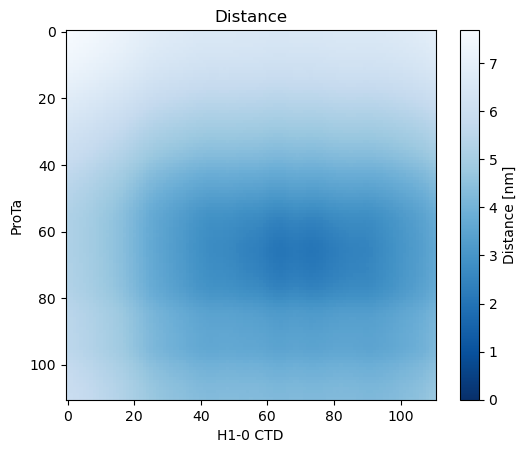

In [5]:
# Plotting distance contact map
prota_len = (residues['chain_id'] == 'ProTa').sum()
plt.imshow(distances.mean(axis=0)[:prota_len,prota_len:], vmin=0, vmax=4, cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Distance")
plt.xlabel("H1-0 CTD")
plt.ylabel("ProTa")
plt.colorbar(label="Distance [nm]")

In [ ]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(traj)

# Calculating interaction energies
energies = {
    'Ashbaugh-Hatch': 'AH',
    'Debye-Hückel': 'DH'
}
for p, e in energies.items():
    energies[p] = analyse_utils.compute_energy(traj, potentials=[e])
    energies[p] = md.geometry.squareform(energies[p].T, traj.top.select_pairs('all','all'))



# Plotting energy contact maps
for p, e in energies.items():
    plt.imshow(e.mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))
    plt.title(p)
    plt.xlabel("H1-0 CTD")
    plt.ylabel("ProTa")
    plt.colorbar(label="Interaction energy [J/mol]")
    plt.show()

plt.imshow(sum(energies.values()).mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Total")
plt.xlabel("H1-0 CTD")
plt.ylabel("ProTa")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

In [6]:
# Calculating interaction energies
energies = {
    'Ashbaugh-Hatch': 'AH',
    'Debye-Hückel': 'DH'#,
    #'Harmonic': 'HB'
}
for p, e in energies.items():
    energies[p] = analyse_utils.compute_energy(traj, potentials=[e])
    energies[p] = md.geometry.squareform(energies[p].T, traj.top.select_pairs('all','all'))

/tmp/ipykernel_15101/1601908699.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(e.mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))


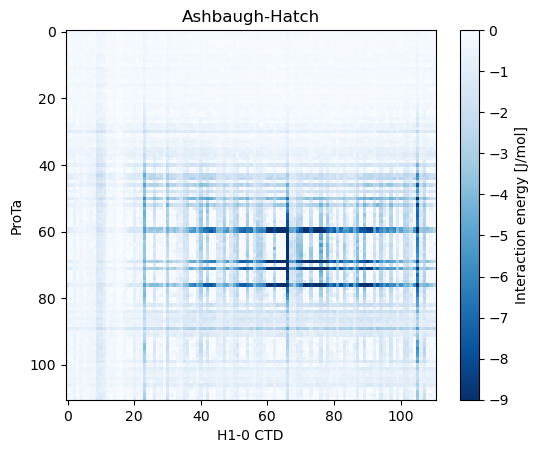

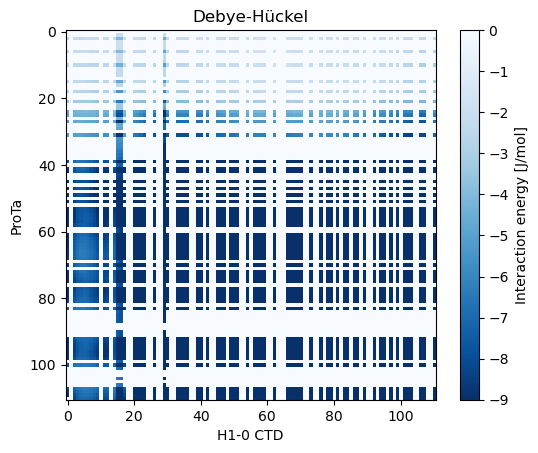

/tmp/ipykernel_15101/1601908699.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(sum(energies.values()).mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))


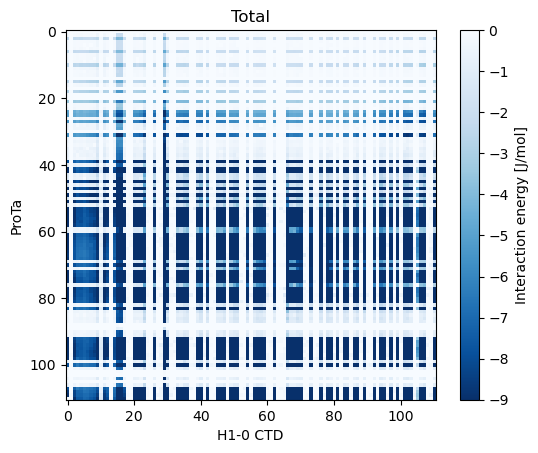

In [13]:
# Plotting energy contact maps
for p, e in energies.items():
    plt.imshow(e.mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))
    plt.title(p)
    plt.xlabel("H1-0 CTD")
    plt.ylabel("ProTa")
    plt.colorbar(label="Interaction energy [J/mol]")
    plt.show()

plt.imshow(sum(energies.values()).mean(axis=0)[:prota_len,prota_len:]*1000, vmin=-9, vmax=0, cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Total")
plt.xlabel("H1-0 CTD")
plt.ylabel("ProTa")
plt.colorbar(label="Interaction energy [J/mol]")
plt.show()

##### Center of mass

In [24]:
# Computing center of mass for each protein
com_H10 = analyse_utils.compute_com(traj.atom_slice(residues.res[residues.chain_id == 'H1-0 CTD']))
com_ProTa = analyse_utils.compute_com(traj.atom_slice(residues.res[residues.chain_id == 'ProTa']))
# Computing eucledian distance between COM
com_diff = (((com_H10-com_ProTa)**2).sum(axis=1))**0.5

Text(0, 0.5, 'Euclidean distance [nm]')

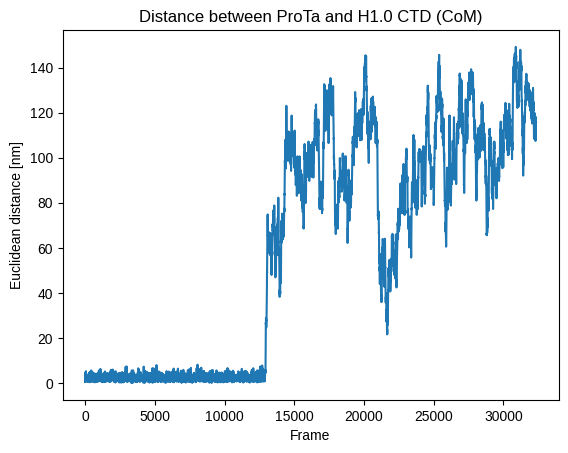

In [25]:
# Plotting COM difference over time
plt.plot(com_diff)
plt.title("Distance between ProTa and H1.0 CTD (CoM)")
plt.xlabel("Frame")
plt.ylabel("Euclidean distance [nm]")

Text(0, 0.5, 'Count')

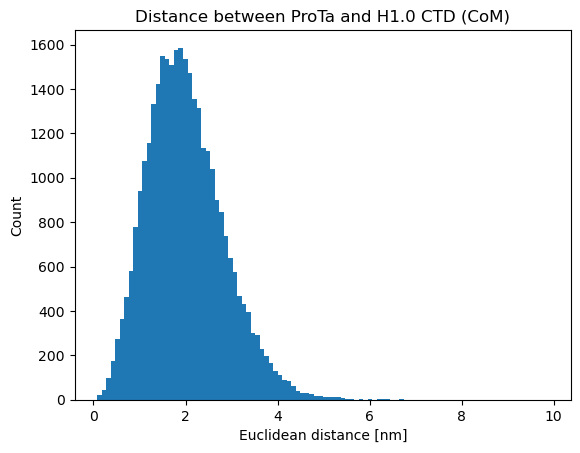

In [9]:
# Plotting COM difference distribution
plt.hist(com_diff, bins=100)
plt.title("Distance between ProTa and H1.0 CTD (CoM)")
plt.xlabel("Euclidean distance [nm]")
plt.ylabel("Count")

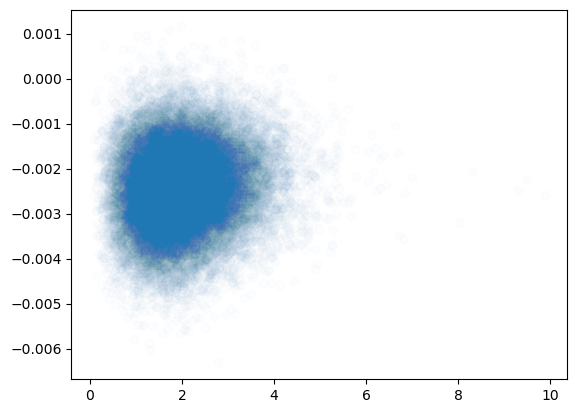

In [11]:
# Plotting CoM distance vs interaction energy
plt.scatter(com_diff, sum(energies.values()).mean(axis=(1,2)), alpha=0.01)

In [9]:
# Saving topology of furthest-distance frame
traj[com_diff == com_diff.max()].save('distant.pdb')

##### $K_D$ calculation

In [ ]:
# Loading precalculated energy data
data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
data

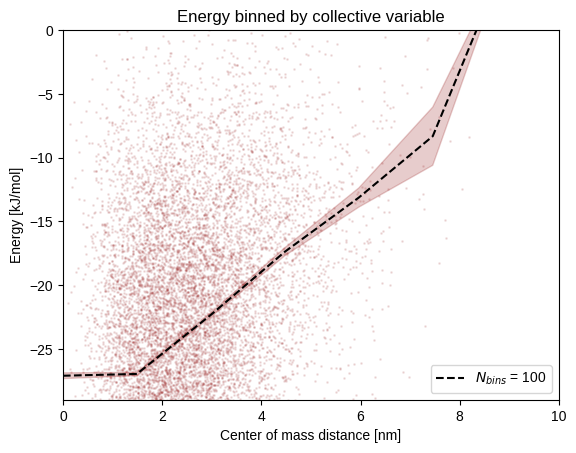

In [69]:
# Binning energy by collective variable
col_var_name = 'Center of mass distance [nm]'
collective_variable = data[col_var_name]
energy = data.iloc[:,[0,1]].sum(axis=1)
bins = 100

bin_edges = np.linspace(0, np.max(collective_variable), bins + 1)
bin_indices = np.digitize(collective_variable, bin_edges)
mean_energy = np.zeros(bins)
err_energy = np.zeros(bins)
for i in range(bins):
    bin_mask = (bin_indices == i + 1)
    mean_energy[i] = np.mean(energy[bin_mask])
    err_energy[i] = np.std(energy[bin_mask])/np.sqrt(bin_mask.sum())

# Plotting
plt.plot(bin_edges[:-1], mean_energy, linestyle='--', color='black')
plt.fill_between(bin_edges[:-1], mean_energy-err_energy, mean_energy+err_energy, alpha=0.2, color='darkred')
plt.ylim(top=0)
plt.xlim(left=0, right=10)
plt.scatter(collective_variable, energy, alpha=0.1, s=1, color='darkred')
plt.xlabel(col_var_name)
plt.ylabel('Energy [kJ/mol]')
plt.title('Energy binned by collective variable')
plt.legend(['$N_{bins}$ = '+f'{bins}'])
plt.show()

In [73]:
data[data['Center of mass distance [nm]'] > 10]

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm]
0,5.683340,0.078064,90.666080,95.360067
1,5.683340,0.078064,89.405460,96.143953
2,5.683340,0.078064,89.580100,96.772340
3,5.683340,0.078064,88.563810,97.601834
4,5.683340,0.078064,89.505066,98.311612
...,...,...,...,...
31995,5.683338,0.078064,16.546970,25.009839
31996,5.683339,0.078064,19.502882,25.509693
31997,5.683338,0.078064,16.602660,25.969247
31998,5.683338,0.078064,15.685282,26.089715


In [ ]:
from conditions import conditions
kB = 8.314462618e-3 # kJ/(mol·K)
T = conditions.loc['ionic_240'].temp
N_A = 6.022e+23 # 1/mol
pi = np.pi

In [ ]:
E = mean_energy
r = bin_edges[:-1]

In [ ]:
from scipy.integrate import simps
1/(4*pi*N_A*simps((np.exp(-E/(kB*T)) * r**2), r))

9.737136407199813e-35

#### All conditions

In [27]:
# Loading trajectories
conds = ["default", "Borgia_in_silico", "ionic_165", "ionic_180", "ionic_205", "ionic_240", "ionic_290", "ionic_330", "ionic_340"]
traj = {}
residues = {}
chain_map = {
    0: 'ProTa',
    1: 'H1-0 CTD'
}
for cond in conds:
    dir = f"results/two_chain/{cond}/H1-0_PROTA_WT"
    traj[cond] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")
    residues[cond] = simulate_utils.extract_sequences(f"{dir}/top.pdb")
    residues[cond]['chain_id'] = residues[cond]['chain'].map(chain_map)

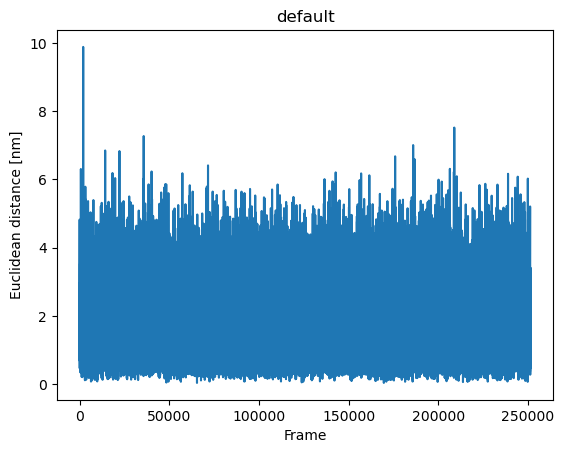

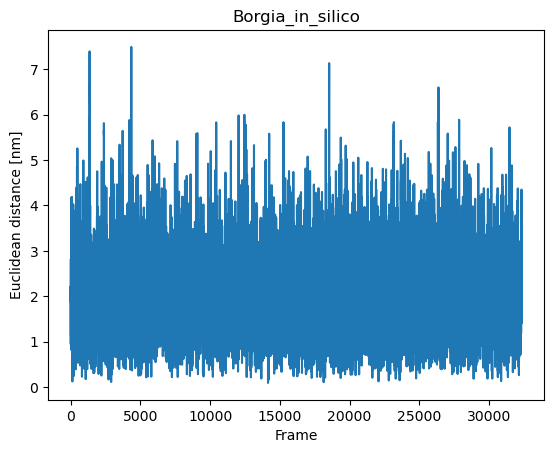

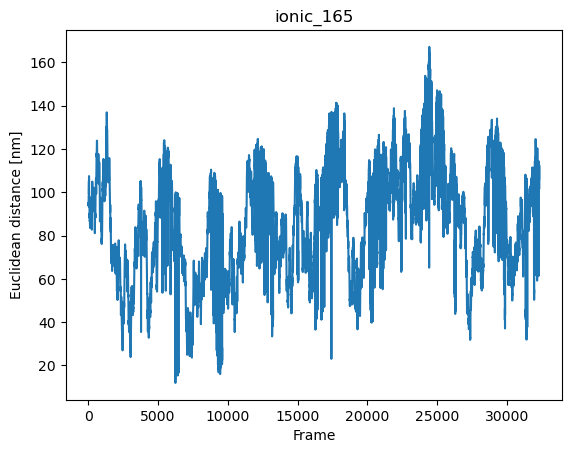

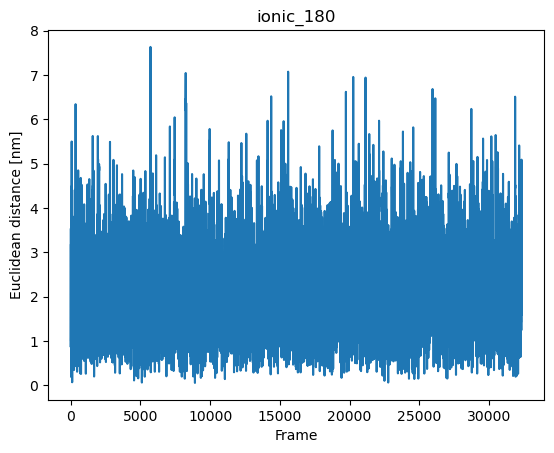

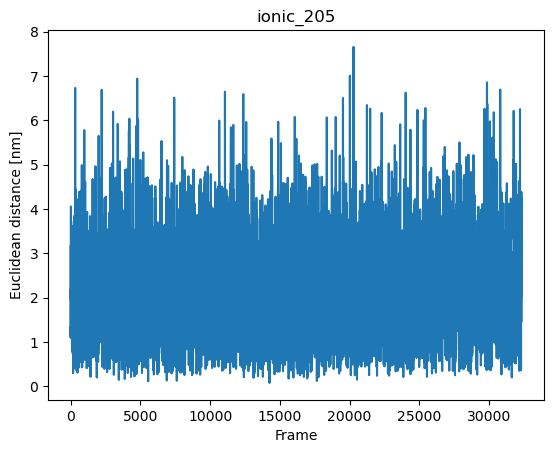

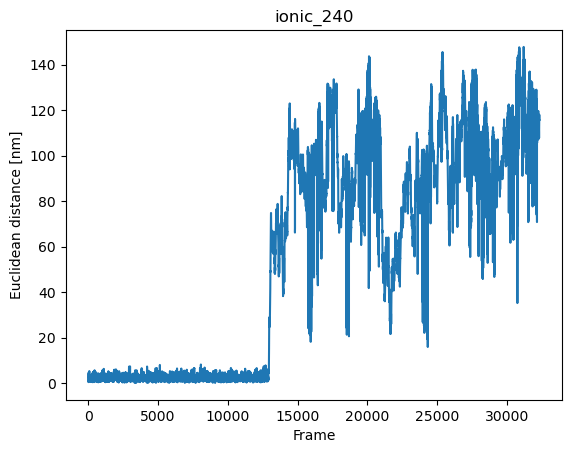

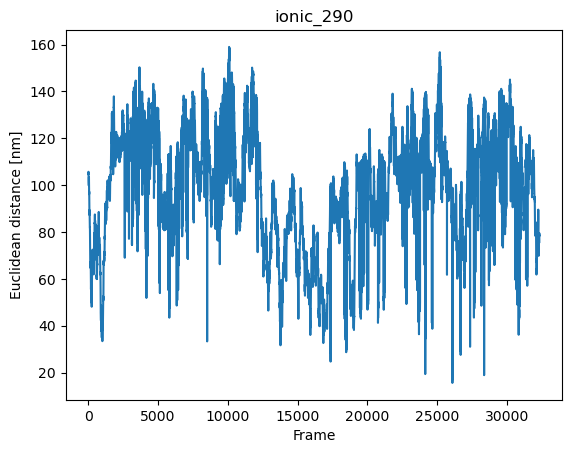

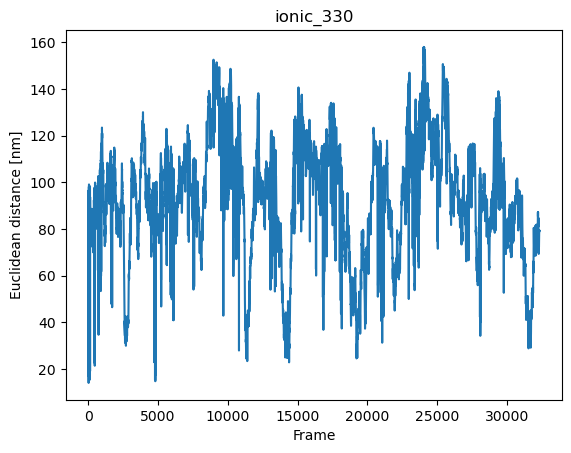

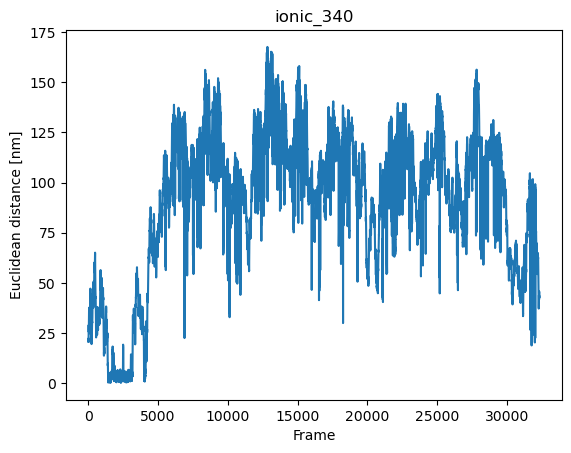

In [28]:
# Computing center of mass c
for cond in conds:
    com_H10 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain_id == 'H1-0 CTD']), traj[cond].atom_slice(residues[cond].res[residues[cond].chain_id == 'H1-0 CTD']))
    com_ProTa = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain_id == 'ProTa']), traj[cond].atom_slice(residues[cond].res[residues[cond].chain_id == 'ProTa']))
    com_diff = (((com_H10-com_ProTa)**2).sum(axis=1))**0.5
    plt.plot(com_diff)
    plt.title(cond)
    plt.xlabel("Frame")
    plt.ylabel("Euclidean distance [nm]")
    plt.show()
    traj[cond][com_diff == com_diff.max()].save(f'results/two_chain/distant_frames/distant_{cond}.pdb')

In [11]:
# Loading precalcualted interaction energies
conds = ["default", "Borgia_in_silico", "ionic_165", "ionic_180", "ionic_205", "ionic_240", "ionic_290", "ionic_330", "ionic_340"]
datas = {}
for cond in conds:
    dir = f"results/two_chain_100nm/{cond}/H1-0_PROTA_WT"
    datas[cond] = pd.read_csv(f"{dir}/interaction_energy.csv")
    datas[cond]['Total energy [kJ/mol]'] = datas[cond]['Ashbaugh-Hatch [kJ/mol]'] + datas[cond]['Debye-Hückel [kJ/mol]']

In [12]:
datas[cond]

,Unnamed: 0,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol]
0,0,5.68334,0.022908,25.756397,32.561631,5.706247
1,1,5.68334,0.022908,26.151253,32.467017,5.706247
2,2,5.68334,0.022908,26.142920,32.798092,5.706247
3,3,5.68334,0.022908,27.699669,33.410881,5.706247
4,4,5.68334,0.022908,29.731176,34.489004,5.706248
...,...,...,...,...,...,...
30995,30995,5.68334,0.022908,92.234000,96.872145,5.706248
30996,30996,5.68334,0.022908,91.633390,96.870406,5.706248
30997,30997,5.68334,0.022908,89.387100,97.005805,5.706248
30998,30998,5.68334,0.022908,90.676650,97.745660,5.706248


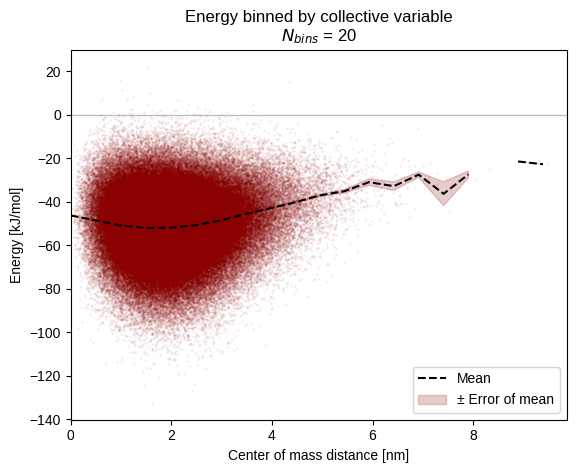

default 64.91186410082365


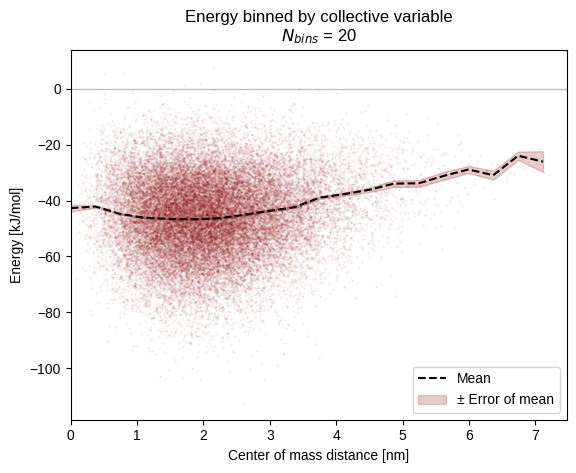

Borgia_in_silico 1454.8967958400156


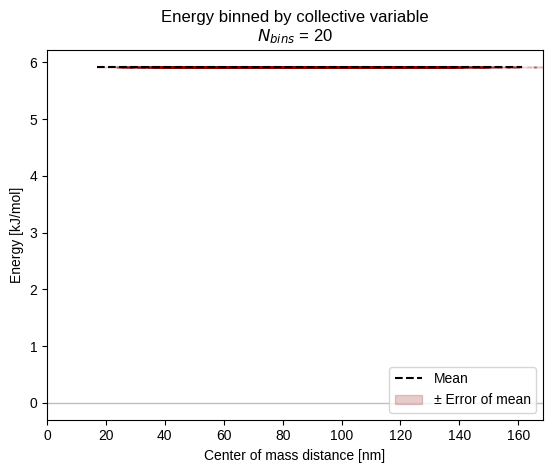

ionic_165 87.7425947584377


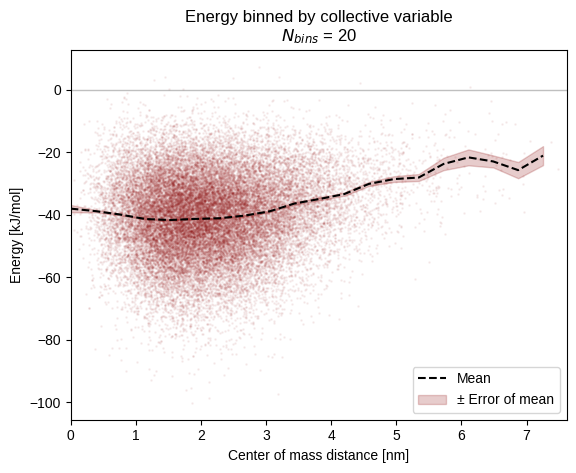

ionic_180 3259.4651124515294


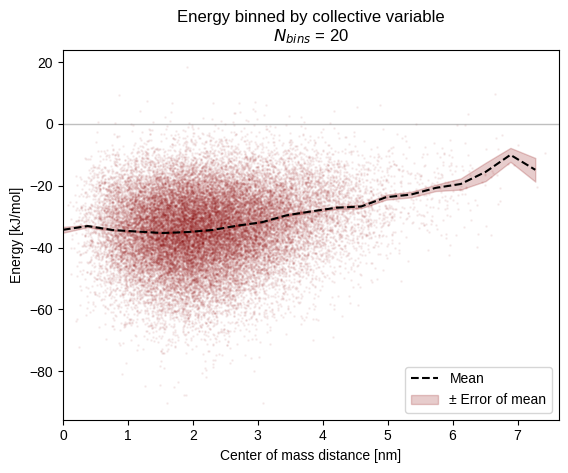

ionic_205 545.930207507409


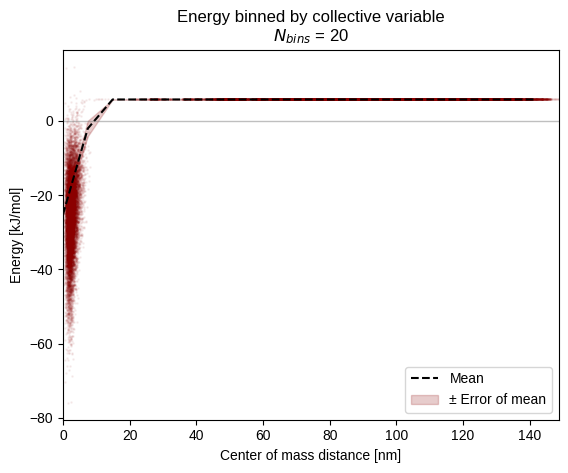

ionic_240 10.253461475052266


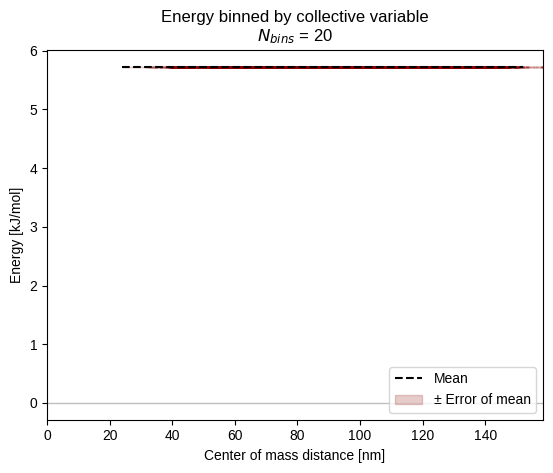

ionic_290 104.8259029342968


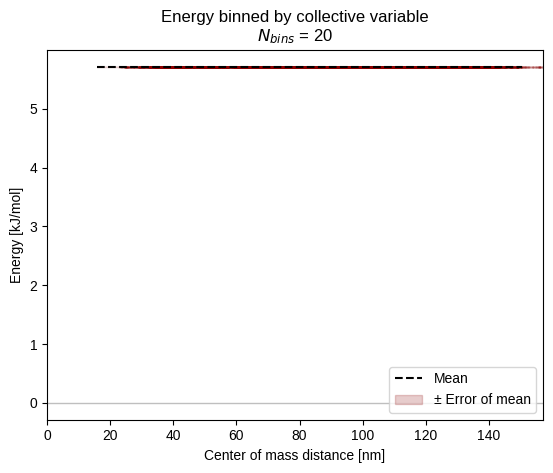

ionic_330 108.08277695217821


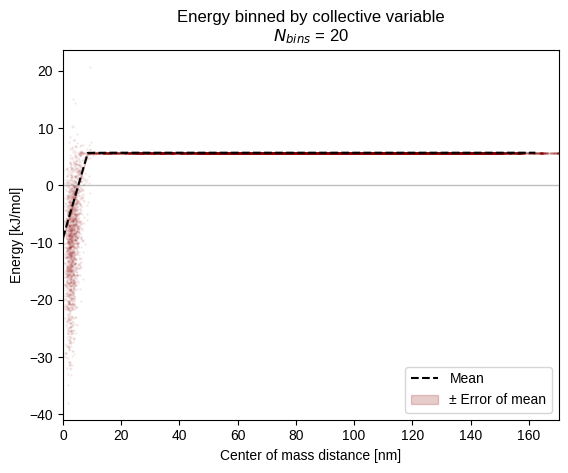

ionic_340 84.43484070702553


In [16]:
from conditions import conditions
for cond in conds:
    Kd = analyse_utils.compute_Kd(datas[cond]['Total energy [kJ/mol]'], datas[cond]['Center of mass distance [nm]'], conditions.loc[cond].T, 20)
    print(cond, Kd)

#### Smaller box size, 240 mM

In [2]:
# Loading trajectory
dir = "results/two_chain_25nm/ionic_240/H1-0_PROTA_WT_25nm"
traj = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")
residues = simulate_utils.extract_sequences(traj.top)
traj

<mdtraj.Trajectory with 664666 frames, 222 atoms, 222 residues, and unitcells at 0x7f451f7281c0>

In [84]:
# Mapping chains to proteins
chain_map = {
    1: 'ProTa',
    0: 'H1-0 CTD'
}
residues['chain_name'] = residues['chain'].map(chain_map)
residues.groupby('chain_name').q.sum()

chain_name
H1-0 CTD    42
ProTa      -44
Name: q, dtype: int64

##### Contact map: Distance

/tmp/ipykernel_5886/3881706357.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances[:1000].mean(axis=0)[:H10_len,H10_len:], vmin=0, vmax=4, cmap=plt.cm.get_cmap('Blues_r'))


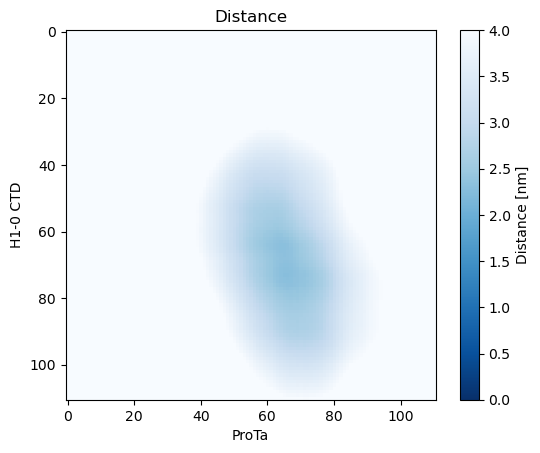

In [25]:
# Plotting distance contact map
H10_len = (residues['chain_id'] == 'H1-0 CTD').sum()
plt.imshow(distances.mean(axis=0)[:H10_len,H10_len:], vmin=0, vmax=4, cmap=plt.cm.get_cmap('Blues_r'))
plt.title("Distance")
plt.ylabel("H1-0 CTD")
plt.xlabel("ProTa")
plt.colorbar(label="Distance [nm]")

In [ ]:
# Saving frames with no interchain interactions
traj[distances.min(axis=0) > 4].save_dcd("unbound.dcd")

##### Contact map: Energy

In [ ]:
# Calculating interchain energy
pairs = traj.top.select_pairs('chainid 0', 'chainid 1')
ah, dh = analyse_utils.compute_energy(traj[:10000], cond='ionic_240', pairs_ij=pairs, ah=True, dh=True)

Text(0, 0.5, 'H1.0 CTD')

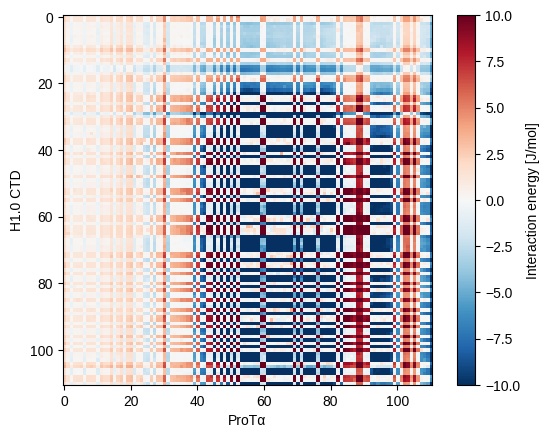

In [37]:
map = md.geometry.squareform(ah+dh, pairs).mean(axis=0)
map = map[np.unique(pairs[:,0])][:, np.unique(pairs[:,1])]
plt.imshow(map*1000, cmap='RdBu_r', interpolation='none', vmin=-10, vmax=10)
plt.colorbar(label="Interaction energy [J/mol]")
plt.xlabel("ProTα")
plt.ylabel("H1.0 CTD")

##### Center of mass

In [34]:
# Computing center of mass for each protein
com_H10 = analyse_utils.compute_com(traj.atom_slice(residues.res[residues.chain_name == 'H1-0 CTD']))
com_ProTa = analyse_utils.compute_com(traj.atom_slice(residues.res[residues.chain_name == 'ProTa']))
# Computing eucledian distance between COM
com_diff = (((com_H10-com_ProTa)**2).sum(axis=1))**0.5

Text(0, 0.5, 'Euclidean distance [nm]')

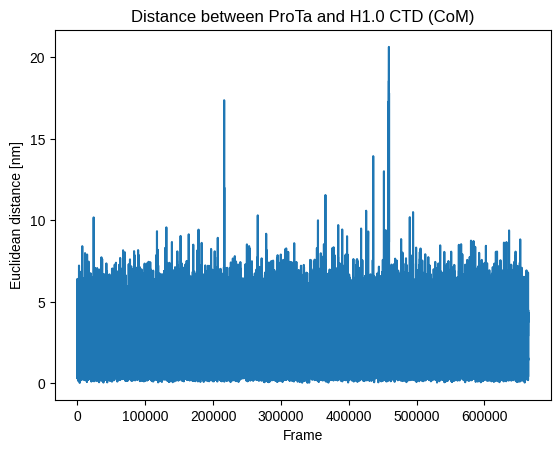

In [35]:
# Plotting COM difference over time
plt.plot(com_diff)
plt.title("Distance between ProTa and H1.0 CTD (CoM)")
plt.xlabel("Frame")
plt.ylabel("Euclidean distance [nm]")

In [14]:
# Saving frames with high CoM differences
traj[com_diff > 10].save_dcd("max.dcd")

Text(0, 0.5, 'Count')

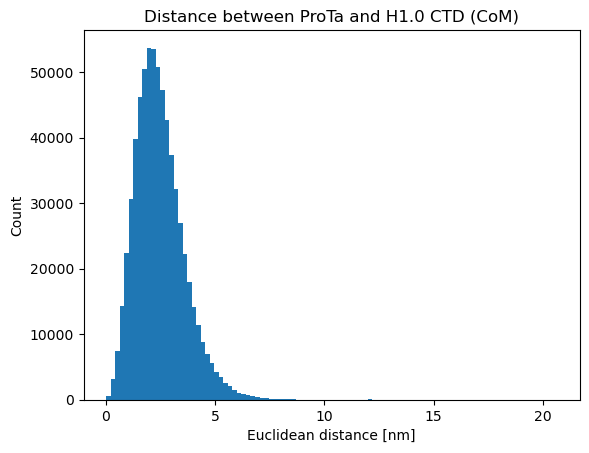

In [8]:
# Plotting COM difference distribution
plt.hist(com_diff, bins=100)
plt.title("Distance between ProTa and H1.0 CTD (CoM)")
plt.xlabel("Euclidean distance [nm]")
plt.ylabel("Count")

##### $K_D$

In [3]:
# Loading precalculated energy data
data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
data

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol]
0,-6.371284,-24.438430,0.551102,1.462695,-30.809713
1,-5.454110,-15.770919,0.555073,1.606574,-21.225030
2,-0.926603,-29.049085,0.577265,2.153136,-29.975688
3,0.809667,-20.164071,0.579350,2.477843,-19.354404
4,-0.795373,-16.527539,0.556496,2.827909,-17.322912
...,...,...,...,...,...
663995,2.539030,-23.083741,0.470810,2.554746,-20.544711
663996,9.796581,-13.088540,0.515811,3.295860,-3.291959
663997,2.485903,-14.016520,0.586212,3.648343,-11.530616
663998,0.427425,-17.066712,0.547321,3.689130,-16.639287


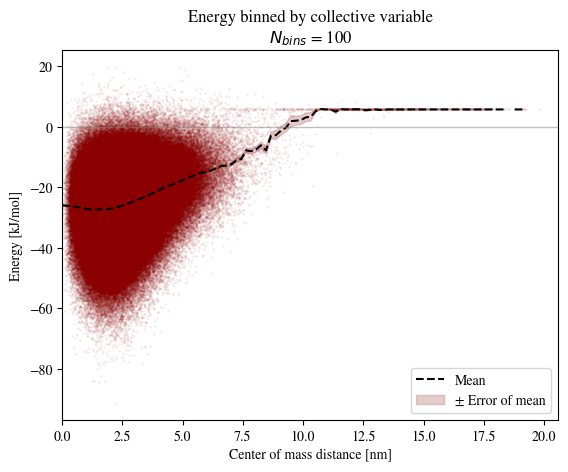

In [10]:
# Binning energy by collective variabl
collective_variable = data['Center of mass distance [nm]']
energy = data['Total energy [kJ/mol]']

bins=100
bin_edges = np.linspace(0, np.max(collective_variable), bins + 1)
bin_indices = np.digitize(collective_variable, bin_edges)
mean_energy = np.zeros(bins)
err_energy = np.zeros(bins)
for i in range(bins):
    bin_mask = (bin_indices == i + 1)
    mean_energy[i] = np.mean(energy[bin_mask])
    err_energy[i] = np.std(energy[bin_mask])/np.sqrt(bin_mask.sum())

# Plotting
plt.plot(bin_edges[:-1], mean_energy, linestyle='--', color='black', label='Mean')
plt.fill_between(bin_edges[:-1], mean_energy-err_energy, mean_energy+err_energy, alpha=0.2, color='darkred', label='± Error of mean')
xlim = plt.xlim(left=0)
plt.hlines(0, *xlim, linestyles='-', color='grey', linewidth=1, alpha=0.5)
plt.scatter(collective_variable, energy, alpha=0.05, s=1, color='darkred')
plt.xlabel('Center of mass distance [nm]')
plt.ylabel('Energy [kJ/mol]')
plt.title('Energy binned by collective variable'+'\n$N_{bins}$ = '+f'{bins}')
plt.legend(loc='lower right')
plt.show()

In [11]:
E = mean_energy[~np.isnan(mean_energy)] - mean_energy[~np.isnan(mean_energy)].max()# kJ/mol
r = ((bin_edges[:-1] + bin_edges[1:])/2*1e-8)[~np.isnan(mean_energy)] # dm

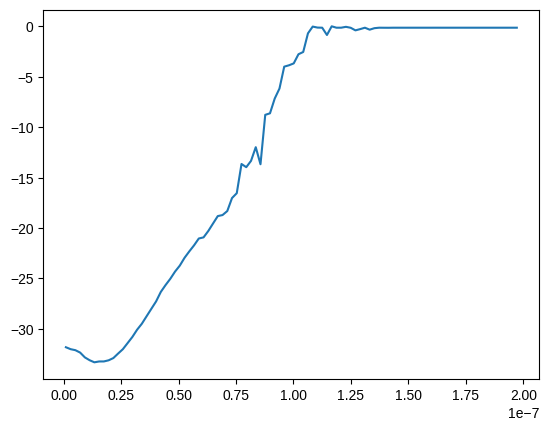

In [14]:
plt.plot(r,E)

In [13]:
kB = 8.314462618e-3 # kJ/(mol·K)
T = 298 # K
N_A = 6.022e+23 # 1/mol
pi = np.pi

from scipy.integrate import simpson
Kd = 1/(4*pi*N_A*simpson((np.exp(-E/(kB*T)) * r**2), r)) # M
Kd * 1e9 # nM

18.914580743577883

### Three chain wild type ProTa - H1.0[CTD]

In [28]:
# Loading trajectories
top = "H1-0_2xPROTA_WT"
conds = ["default", "Borgia_in_silico", "ionic_165", "ionic_180", "ionic_205", "ionic_240", "ionic_290", "ionic_330", "ionic_340"]
charge_map = {
    42: 'H1-0 CTD',
    -44: 'ProTa'
}

# Loading trajectories and gathering sequence data
traj = {}
residues = {}
for cond in conds:
    dir = f"results/three_chain/{cond}/{top}"
    traj[cond] = md.load_dcd(f"{dir}/pretraj.dcd", f"{dir}/top.pdb")[1000:]
    residues[cond] = simulate_utils.extract_sequences(f"{dir}/top.pdb")
    

# Mapping chains by charge
chain_map = {}
for i, q in residues[conds[0]].groupby('chain').q.sum().items():
    chain_map[i] = charge_map[q]
for cond in conds:
    residues[cond]['chain_id'] = residues[cond]['chain'].map(chain_map)

dcdplugin) Warning: DCD header claims 14756 frames, file size indicates there are actually 14757 frames


In [30]:
# Centering trajectories around middle protein
for cond in conds:
    center_chain = 1
    chains = traj[cond].topology.find_molecules()
    assert len(chains) == 3, f"Topology for '{cond}' has wrong CONECT lines!"
    anchor_chain = [traj[cond].topology.find_molecules()[center_chain]]
    traj[cond].image_molecules(inplace=True, anchor_molecules=anchor_chain)

In [19]:
# Saving recentered trajs
for cond in conds:
    dir = f"results/three_chain/{cond}/{top}"
    traj[cond].save_dcd(f"{dir}/traj.dcd")

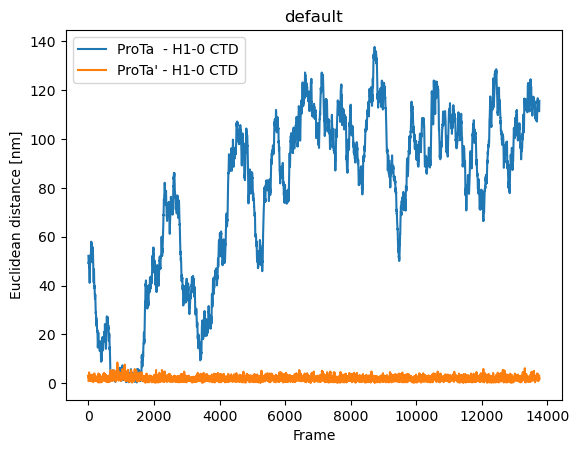

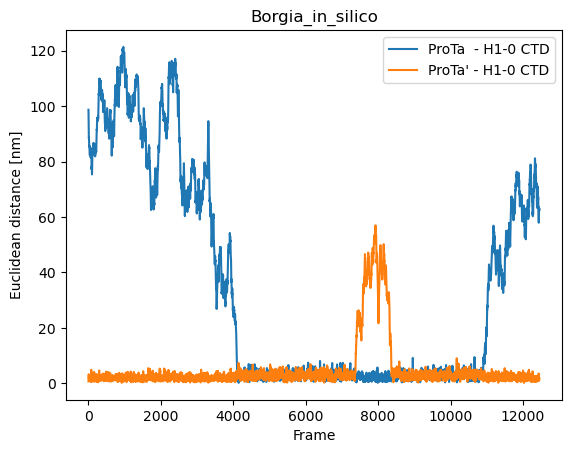

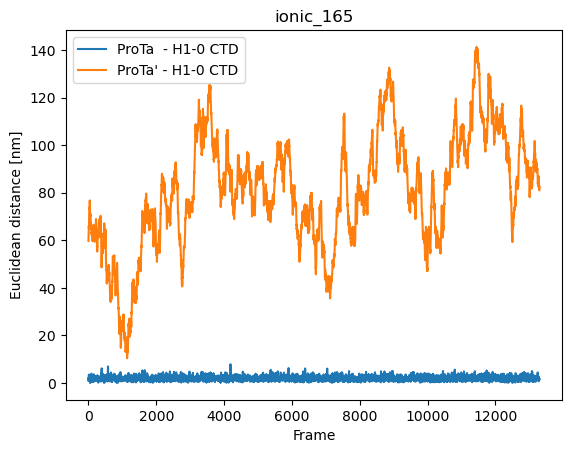

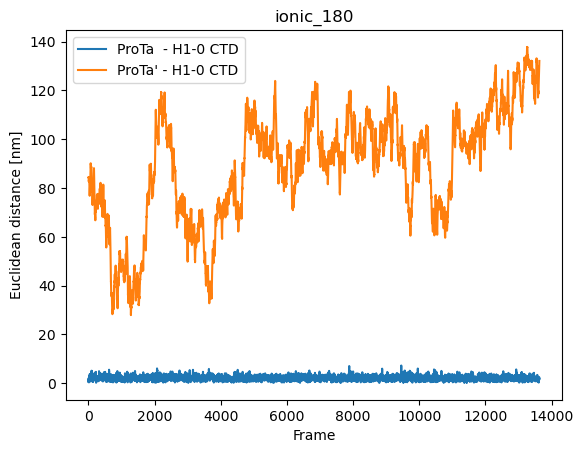

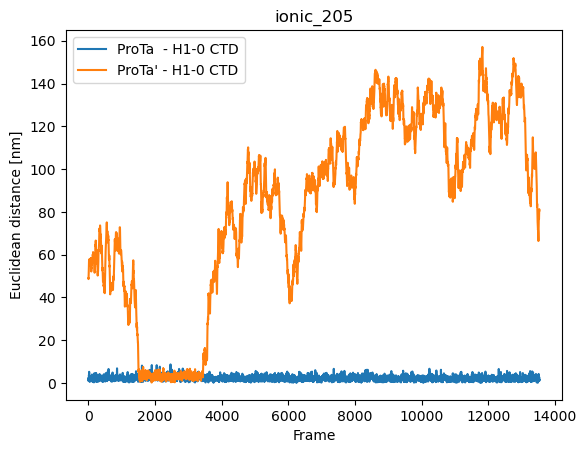

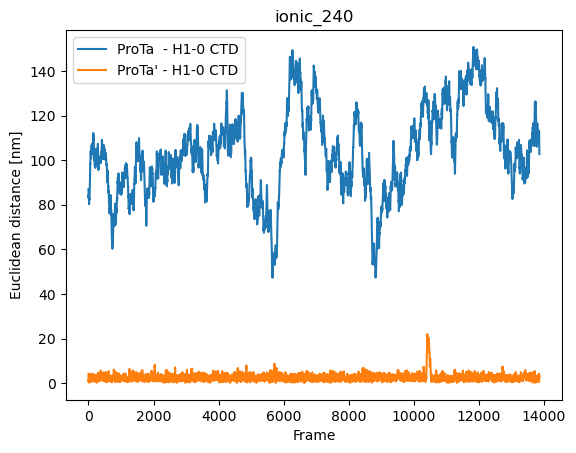

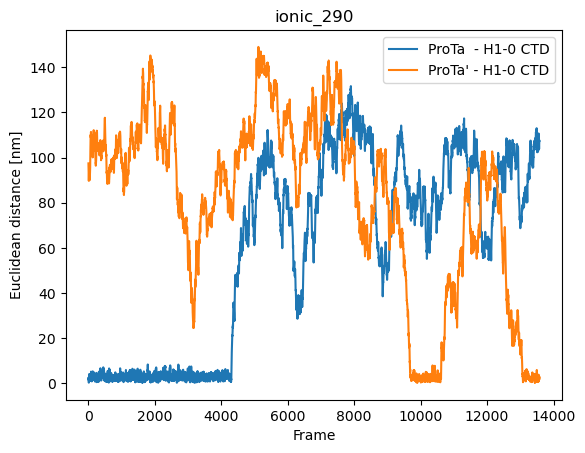

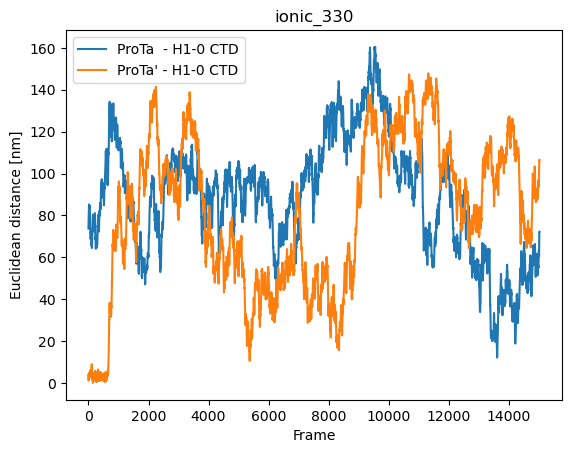

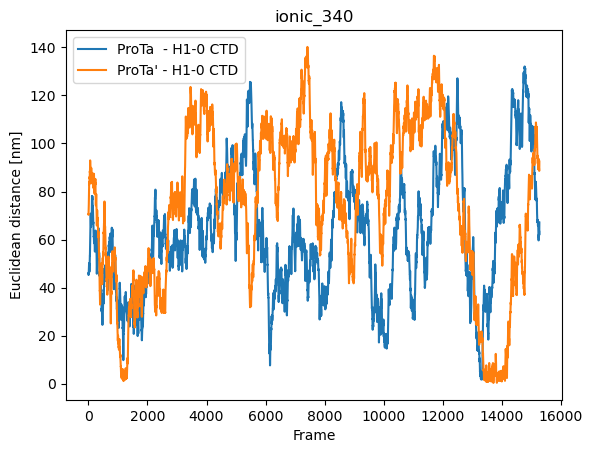

In [31]:
# Computing center of mass c
for cond in conds:
    c1 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 0]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 0]))
    c2 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 1]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 1]))
    c3 = analyse_utils.compute_com(''.join(residues[cond].aa[residues[cond].chain == 2]), traj[cond].atom_slice(residues[cond].res[residues[cond].chain == 2]))
    com_diff_1 = (((c1-c2)**2).sum(axis=1))**0.5
    com_diff_2 = (((c3-c2)**2).sum(axis=1))**0.5
    plt.plot(com_diff_1, label=f"{chain_map[0]}  - {chain_map[1]}")
    plt.plot(com_diff_2, label=f"{chain_map[2]}' - {chain_map[1]}")
    plt.legend()
    plt.title(cond)
    plt.xlabel("Frame")
    plt.ylabel("Euclidean distance [nm]")
    plt.show()